In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%matplotlib inline

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Datasets

In [ ]:
test_data = pd.read_csv("testing_data_transform.csv.gz", compression="gzip")
test_data.head()

In [ ]:
training_data = pd.read_csv("training_data_transform.csv.gz", compression="gzip")
training_data.head()

# Training Data

In [ ]:
vars = list(set(test_data.columns) - {"data_ind", "index"})
vars

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data[varaibles],
                                                        train_data.signal, 
                                                        test_size=0.10, 
                                                        random_state=42)

In [ ]:
idx = ~X_train.TX_pair.isna()
X_train.loc[~idx, list(set(X_train.columns) - {"TX", "TY", "X", "Y", "Z"})] = np.random.normal(size=(27876, 10))

idx = ~X_valid.TX_pair.isna()
X_valid.loc[~idx, list(set(X_valid.columns) - {"TX", "TY", "X", "Y", "Z"})] = np.random.normal(size=(3208, 10))

del idx

# XGBoost Model

In [0]:
import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [0]:
param_grid = {
        'n_estimators':[10, 20], 
        'max_depth':[15],
}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]

clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, 
                                     subsample=0.8,
                                     colsample_bytree=0.8, 
                                     n_jobs=-1, 
                                     tree_method='gpu_hist', 
                                     gpu_id=0,
                                     warm_start=True), 
                   param_grid=param_grid, 
                   n_jobs=-1,
                   scoring='roc_auc',
                   verbose=7)

In [27]:
%%time

clf.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 22.4min remaining: 22.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 33.2min remaining: 14.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 43.1min finished


CPU times: user 6min 50s, sys: 4min 39s, total: 11min 29s
Wall time: 54min 35s


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier_tmp(base_score=0.5, booster='gbtree',
                                         colsample_bylevel=1,
                                         colsample_bynode=1,
                                         colsample_bytree=0.8, gamma=0,
                                         gpu_id=0, learning_rate=0.05,
                                         max_delta_step=0, max_depth=3,
                                         min_child_weight=1, missing=None,
                                         n_estimators=100, n_jobs=-1,
                                         nthread=None,
                                         objective='binary:logistic',
                                         random_state=0, reg_alpha=0,
                                         reg_lambda=1, scale_pos_weight=1,
                                         seed=None, silent=None, subsample=0.8,
                                         tree_method=

In [28]:
clf.best_estimator_

XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
                  learning_rate=0.05, max_delta_step=0, max_depth=15,
                  min_child_weight=1, missing=None, n_estimators=20, n_jobs=-1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                  silent=None, subsample=0.8, tree_method='gpu_hist',
                  verbosity=1)

In [0]:
xgb_class = XGBClassifier_tmp(base_score=0.5, 
                              booster='gbtree', 
                              tree_method='gpu_hist', 
                              gpu_id=0,
                              colsample_bylevel=1,
                              colsample_bytree=0.8, 
                              gamma=0, 
                              learning_rate=0.05,
                              max_delta_step=0, 
                              max_depth=15, 
                              min_child_weight=1, 
                              missing=None,
                              n_estimators=100, 
                              nthread=None,
                              objective='binary:logistic', 
                              random_state=0, 
                              reg_alpha=0,
                              reg_lambda=1, 
                              scale_pos_weight=1, 
                              seed=None, 
                              silent=True,
                              subsample=0.8, 
                              n_jobs=-1)

### Validation

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

def evaluate_performace(y_true, y_pred, threshold=0.5):
    y_probs = np.hstack([1-y_pred.reshape(-1, 1), y_pred.reshape(-1, 1)])
    y_pred = y_pred >= threshold
    print("Accuracy Score: ", accuracy_score(y_true, y_pred))
    print("Precision Score: ", precision_score(y_true, y_pred))
    print("Recall Score: ", recall_score(y_true, y_pred))

    plot_confusion_matrix(y_true, y_pred, normalize=True, cmap="winter")
    plot_roc(y_true, y_probs, classes_to_plot=[0], plot_macro=False, plot_micro=False)
    plt.show()

In [0]:
y_pred = clf.predict(X_valid)

Accuracy Score:  0.8354126485637042
Precision Score:  0.8394096648259574
Recall Score:  0.8294819922198015


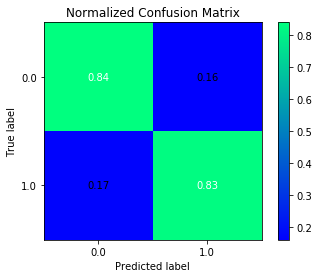

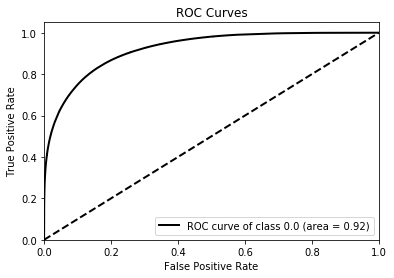

In [31]:
evaluate_performace(y_valid, y_pred, threshold=0.5)

# Final Prediction

In [0]:
clf.fit(X_valid, y_valid)

In [32]:
X_test = test_data[vars]

100%|██████████| 11/11 [00:43<00:00,  3.93s/it]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



CPU times: user 49.3 s, sys: 713 ms, total: 50.1 s
Wall time: 50 s


In [0]:
idx = ~X_test.TX_pair.isna()
X_test.loc[~idx, list(set(X_test.columns) - {"TX", "TY", "X", "Y", "Z"})] = np.random.normal(size=(128639, 10))

In [0]:
probas = clf.predict(X_test, batch_size=5000)

In [0]:
df = pd.DataFrame({'id': test_data["index"], 'signal': probas.reshape(-1)}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [0]:
agg.to_csv('submission.csv.gz', index=True, compression='gzip')

In [ ]:
agg